https://tensorflow.google.cn/guide/datasets

tf.data 模块包含一系列类，可让您轻松地加载数据、操作数据并通过管道将数据传送到模型中。

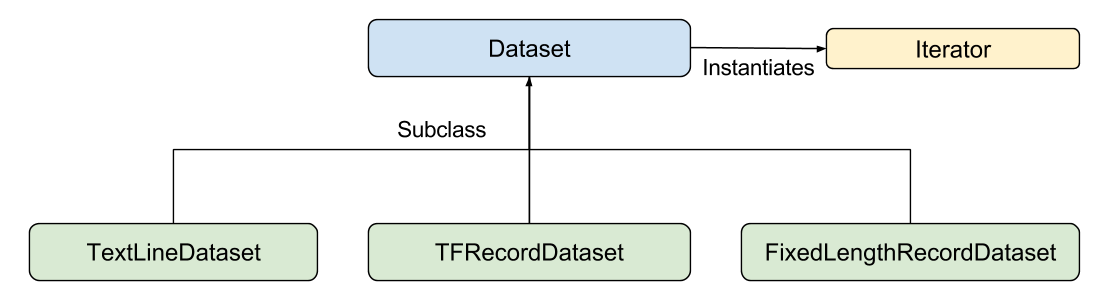

各个类如下所示：

* Dataset - 包含创建和转换数据集的方法的基类。您还可以通过该类从内存中的数据或 Python 生成器初始化数据集。
* TextLineDataset - 从文本文件中读取行。
* TFRecordDataset - 从 TFRecord 文件中读取记录。
* FixedLengthRecordDataset - 从二进制文件中读取具有固定大小的记录。
* Iterator - 提供一次访问一个数据集元素的方法。

In [2]:
import numpy as np
import tensorflow as tf

tf.enable_eager_execution()

print("TensorFlow version: {}".format(tf.VERSION))
print("Eager execution: {}".format(tf.executing_eagerly()))

TensorFlow version: 1.14.0
Eager execution: True


# 创建dataset实例
## 通过 NumPy 数组
如果您的所有输入数据都适合存储在内存中，则根据输入数据创建 Dataset 的最简单方法是将它们转换为 tf.Tensor 对象，并使用 Dataset.from_tensor_slices()。

**注意：本质上其它的数据来源（如CSV等）都可以通过先转化为ndarray，在创建dataset**

In [21]:
arr = np.random.normal(0, 1, (100, 5))

features = arr[:, :4]

labels = arr[:, 4]

dataset = tf.data.Dataset.from_tensor_slices((features, labels))

dataset

<DatasetV1Adapter shapes: ((4,), ()), types: (tf.float64, tf.float64)>

In [24]:
for f, l in dataset.take(1):
    print(f)
    print(l)

tf.Tensor([-1.85233906  1.04379927 -0.3932823  -0.72423922], shape=(4,), dtype=float64)
tf.Tensor(0.1768635942121952, shape=(), dtype=float64)


In [5]:
print(tf.compat.v1.data.get_output_types(dataset))  # 
print(tf.compat.v1.data.get_output_shapes(dataset))  

(tf.float64, tf.float64)
(TensorShape([Dimension(4)]), TensorShape([]))


请注意，上面的代码段会将 features 和 labels 数组作为 tf.constant() 指令嵌入在 TensorFlow 图中。这样非常适合小型数据集，但会浪费内存，因为会多次复制数组的内容，并可能会达到 tf.GraphDef 协议缓冲区的 2GB 上限。

作为替代方案，您可以根据 tf.placeholder() 张量定义 Dataset，并在对数据集初始化 Iterator 时馈送 NumPy 数组。

In [9]:
features_placeholder = tf.placeholder(features.dtype, features.shape)
labels_placeholder = tf.placeholder(labels.dtype, labels.shape)

dataset = tf.data.Dataset.from_tensor_slices((features_placeholder, labels_placeholder))
# [Other transformations on `dataset`...]
# dataset = ...
iterator = dataset.make_initializable_iterator()

sess.run(iterator.initializer, feed_dict={features_placeholder: features,
                                          labels_placeholder: labels})

RuntimeError: tf.placeholder() is not compatible with eager execution.

## 通过DataFrame

In [25]:
import pandas as pd

In [26]:
df = pd.DataFrame(arr, columns=list('abcde'))
df.head(2)

,a,b,c,d,e
0,-1.852339,1.043799,-0.393282,-0.724239,0.176864
1,-0.487519,1.087768,0.428366,-0.499344,-1.275869


In [27]:
labels = df.pop('e')
labels[:2]

0    0.176864
1   -1.275869
Name: e, dtype: float64

In [28]:
df.head(2)

,a,b,c,d
0,-1.852339,1.043799,-0.393282,-0.724239
1,-0.487519,1.087768,0.428366,-0.499344


In [29]:
dataset = tf.data.Dataset.from_tensor_slices((dict(df), labels))

In [30]:
dataset

<DatasetV1Adapter shapes: ({a: (), b: (), c: (), d: ()}, ()), types: ({a: tf.float64, b: tf.float64, c: tf.float64, d: tf.float64}, tf.float64)>

In [31]:
for f, l in dataset.take(1):
    print(f)
    print(l)

{'a': <tf.Tensor: id=40, shape=(), dtype=float64, numpy=-1.8523390568584377>, 'b': <tf.Tensor: id=41, shape=(), dtype=float64, numpy=1.0437992669111136>, 'c': <tf.Tensor: id=42, shape=(), dtype=float64, numpy=-0.39328229640318074>, 'd': <tf.Tensor: id=43, shape=(), dtype=float64, numpy=-0.7242392220649666>}
tf.Tensor(0.1768635942121952, shape=(), dtype=float64)


# 创建迭代器

构建了表示输入数据的 Dataset 后，下一步就是创建 Iterator 来访问该数据集中的元素。

单次迭代器是最简单的迭代器形式，仅支持对数据集进行一次迭代，不需要显式初始化。

In [14]:
iterator = dataset.make_one_shot_iterator()

Instructions for updating:
Colocations handled automatically by placer.


In [16]:
iterator.get_next()

(<tf.Tensor: id=18, shape=(4,), dtype=float64, numpy=array([-1.33612669, -0.19647945, -0.32231295, -0.42956847])>,
 <tf.Tensor: id=19, shape=(), dtype=float64, numpy=-0.41165565892866535>)